In [3]:
# .venv\Scripts\activate.bat
import sys
!{sys.executable} -m pip install gender-guesser

In [1]:
import numpy as np
import pandas as pd

# import gender_guesser.detector as gender
import nltk
nltk.download(['punkt','stopwords','vader_lexicon'])
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tag import pos_tag, map_tag # for tagging words
# import text2emotion as te
import matplotlib.pyplot as plt
# %matplotlib inline
import re
# from wordcloud import WordCloud, ImageColorGenerator

from collections import defaultdict

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [4]:
data = pd.read_csv('prof_sentiment.csv')
data.gender_guess.isna().sum()

1

In [5]:
# preview data
data = pd.read_csv('static/data/reviews_50.csv')
data.head(3)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review
0,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 27, 2020",A,One of the BEST profs at UCLA!! Take her if yo...
1,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 23, 2020",A,I don't say this lightly: she is an amazing pr...
2,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 17, 2020",NR,**Extenuating circumstances warning** I took t...


In [6]:
set(data['Grade'])

{' B',
 ' B+',
 ' C+',
 'A',
 'A+',
 'A-',
 'B',
 'B+',
 'B-',
 'C',
 'C+',
 'C-',
 'D',
 'D+',
 'I',
 'NR',
 'P',
 'U',
 nan}

In [7]:
# feature engineering

# name and review
data['First_Name'] = [name[0] for name in data["Professor"].str.split()]
data['Last_Name'] = [name[1] for name in data["Professor"].str.split()]
data['Review'] = [review.lower() for review in data['Review']]
# bigrams
data['Bigrams'] = [list(nltk.bigrams(review.split(' '))) for review in data['Review']]

# gender
data['All_Reviews'] = data.groupby(['Professor'])['Review'].transform(lambda x: ','.join(x)).str.lower()
# data.head(3)
data_gender =  data[['Professor', 'All_Reviews']].drop_duplicates().reset_index(drop=True)
gender_guess = {}
for idx, row in data_gender.iterrows():
    f_prns = [r'\bshe\b',r'\bher\b',r'\bhers\b']
    m_prns = [r'\bhe\b','r\bhim\b',r'\bhis\b']
    f_count = sum([len(re.findall(prn, row['All_Reviews'])) for prn in f_prns])
    m_count = sum([len(re.findall(prn, row['All_Reviews'])) for prn in m_prns])
    # print(f_count,m_count)
    if f_count > m_count:
        gender_guess[row['Professor']] = ('Female')
    elif m_count > f_count:
        gender_guess[row['Professor']] = ('Male')
    else:
        gender_guess[row['Professor']] = ('Unsure (equal or no pronouns)')
    # print(gender_guess)
print(gender_guess)
data['Gender_Pronouns'] = data['Professor'].map(gender_guess)
# # # d = gender.Detector()
# # # data['Gender'] = [d.get_gender(first_name) for first_name in data['First_Name']]

# grade
grade_dict = ['A+','A','A-','B+','B','B-','C+','C','C-','D+','D','D-','F','P','NR']
gpa_dict = [4.0, 4.0, 3.7, 3.3, 3, 2.7, 2.3, 2, 1.7, 1.3, 1, 0.7, 0, 'NA','NA']
grade_gpa_dict = dict(zip(grade_dict, gpa_dict))
grade_gpa_dict

# sentiment
sia = SentimentIntensityAnalyzer()
data['Sentiment'] = [sia.polarity_scores(review) for review in data['Review']]
data['Pos_Score'] = [sent['pos'] for sent in data['Sentiment']]
data['Neg_Score'] = [sent['neg'] for sent in data['Sentiment']]
data['PosNeg_Sentiment'] = [sent['pos'] > sent['neg'] for sent in data['Sentiment']]

# upper div
class_code2 = [code.split(' ')[-1] for code in data['Class Code']]
code_chars = [[char for char in code] for code in class_code2]
num_code = [[char for char in char_list if char.isnumeric()] for char_list in code_chars]
data['Class_Code_Num'] = [int(''.join(nums)) for nums in num_code]
data['Upper_Div'] = [code >= 100 for code in data['Class_Code_Num']]

{'Sherry Gong': 'Female', 'Jasmine Trice': 'Female', 'Peiyun Lee': 'Female', 'Adrienne Lavine': 'Female', 'Sharmila Venugopal': 'Female', 'Scott H Chandler': 'Male', 'David Gorshein': 'Male', 'Sander M Goldberg': 'Male', 'Brent Corbin': 'Male', 'Anish Nag': 'Male', 'Rana Khankan': 'Female', 'J.P. Maloy': 'Male', 'Hung Ding Pham': 'Male', 'Debra B Pires': 'Female', 'Jennifer Casey': 'Female', 'Laurence Lavelle': 'Male', 'Hung V Pham': 'Male', 'Philip Chodrow': 'Male', 'Claudia Pena': 'Female', 'Andrea Ghez': 'Female', 'Caitlin Solone': 'Female', 'Smadar Naoz': 'Female', 'Christy Hazel': 'Female', 'Rose Morris-Wright': 'Female', 'Eric Min': 'Male', 'Vinay Lal': 'Male', 'Laura Cladek': 'Female', 'Maria Cha': 'Female', 'Anthony R Friscia': 'Male', 'Nicolas Christou': 'Male', 'Juana Sanchez': 'Female', 'Kristopher F Fletcher': 'Male', 'Anastassia N Alexandrova': 'Female', 'Christian Evan Beren': 'Male', 'Emily A Carter': 'Female', 'Clover May': 'Female'}


In [8]:
data.head(3)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review,First_Name,Last_Name,Bigrams,All_Reviews,Gender_Pronouns,Sentiment,Pos_Score,Neg_Score,PosNeg_Sentiment,Class_Code_Num,Upper_Div
0,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 27, 2020",A,one of the best profs at ucla!! take her if yo...,Sherry,Gong,"[(one, of), (of, the), (the, best), (best, pro...",one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...",0.232,0.000,True,32,False
1,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 23, 2020",A,i don't say this lightly: she is an amazing pr...,Sherry,Gong,"[(i, don't), (don't, say), (say, this), (this,...",one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.061, 'neu': 0.772, 'pos': 0.167, 'co...",0.167,0.061,True,32,False
2,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 17, 2020",NR,**extenuating circumstances warning** i took t...,Sherry,Gong,"[(**extenuating, circumstances), (circumstance...",one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.067, 'neu': 0.716, 'pos': 0.217, 'co...",0.217,0.067,True,32,False


In [9]:
# add prof last name to filtered words
last_names = [name.split(' ')[-1].lower() for name in data['Professor'].unique()]

In [10]:
# tokenize reviews
review_tokens = [nltk.word_tokenize(review) for review in data['Review']]
# review_tokens[0][:5]
# remove stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['.',',','!', '&','(',')','%', '-',':',"'",';',
                   'class', 'lecture','lectures', 'students','quarter','discussion',
                   'like', 'really','pretty', 'lot', 'much', 'many','well','one','even',
                   'us','took','take','though','gives','things','however','actually',
                   'also', 'would', 'get','go','got','going',
                   'even','know','sure','makes','made',
                   "n't","'s","'ve","'re","'ll"]) # add some stopwords
stop_words.update(last_names)
filt_review_tokens = [[word for word in review if not word.lower() in stop_words] for review in review_tokens]
data['Review_Token'] = filt_review_tokens
data['Review_Filt'] = [' '.join(tokens) for tokens in filt_review_tokens] # filtered for stopwords
data.head(4)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review,First_Name,Last_Name,...,All_Reviews,Gender_Pronouns,Sentiment,Pos_Score,Neg_Score,PosNeg_Sentiment,Class_Code_Num,Upper_Div,Review_Token,Review_Filt
0,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 27, 2020",A,one of the best profs at ucla!! take her if yo...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'comp...",0.232,0.000,True,32,False,"[best, profs, ucla, chance, 100, sometimes, co...",best profs ucla chance 100 sometimes confusing...
1,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 23, 2020",A,i don't say this lightly: she is an amazing pr...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.061, 'neu': 0.772, 'pos': 0.167, 'co...",0.167,0.061,True,32,False,"[say, lightly, amazing, professor, s-tier, obv...",say lightly amazing professor s-tier obviously...
2,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 17, 2020",NR,**extenuating circumstances warning** i took t...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.067, 'neu': 0.716, 'pos': 0.217, 'co...",0.217,0.067,True,32,False,"[*, *, extenuating, circumstances, warning, *,...",* * extenuating circumstances warning * * fina...
3,Sherry Gong,Math 32A,Calculus of Several Variables,Winter 2020,Pre COVID-19,"Submitted March 30, 2020",A,sherry gong is extremely helpful and kind. as ...,Sherry,Gong,...,one of the best profs at ucla!! take her if yo...,Female,"{'neg': 0.039, 'neu': 0.825, 'pos': 0.137, 'co...",0.137,0.039,True,32,False,"[sherry, extremely, helpful, kind, winter, 202...",sherry extremely helpful kind winter 2020 revi...


In [11]:
data.to_csv('reviews_new.csv',index=False)

In [12]:
# male, female data
data_m = data.loc[data['Gender_Pronouns'] == 'Male']
data_f = data.loc[data['Gender_Pronouns'] == 'Female']
print(len(data_f.index))
print(len(data_m.index))

391
446


In [13]:
data_m.head(3)

,Professor,Class Code,Class Name,Term Taken,COVID 19 Flag,Date Submitted,Grade,Review,First_Name,Last_Name,...,All_Reviews,Gender_Pronouns,Sentiment,Pos_Score,Neg_Score,PosNeg_Sentiment,Class_Code_Num,Upper_Div,Review_Token,Review_Filt
108,Scott H Chandler,Neurosc M101A,Neuroscience: From Molecules to Mind -- Cellul...,Fall 2019,Pre COVID-19,"Submitted June 30, 2020",A-,i would say chandler's module was the most dif...,Scott,H,...,i would say chandler's module was the most dif...,Male,"{'neg': 0.061, 'neu': 0.834, 'pos': 0.105, 'co...",0.105,0.061,True,101,True,"[say, module, difficult, 101a, module, heavily...",say module difficult 101a module heavily invol...
109,Scott H Chandler,Neurosc M101A,Neuroscience: From Molecules to Mind -- Cellul...,Fall 2019,Pre COVID-19,"Submitted Dec. 18, 2019",A-,no! ns m101a is not the hardest class you will...,Scott,H,...,i would say chandler's module was the most dif...,Male,"{'neg': 0.109, 'neu': 0.722, 'pos': 0.169, 'co...",0.169,0.109,True,101,True,"[ns, m101a, hardest, ever, curve, start, b, fr...",ns m101a hardest ever curve start b freshmen t...
110,Scott H Chandler,Neurosc M101A,Neuroscience: From Molecules to Mind -- Cellul...,Fall 2020,Pre COVID-19,"Submitted May 10, 2021",P,everyone seems to love dr. chandler for some r...,Scott,H,...,i would say chandler's module was the most dif...,Male,"{'neg': 0.14, 'neu': 0.785, 'pos': 0.075, 'com...",0.075,0.140,False,101,True,"[everyone, seems, love, dr., reason, think, th...",everyone seems love dr. reason think thats gra...


In [14]:
def get_freq_dict(word_list):
    freq_dict = defaultdict( int )
    for w in word_list:
        freq_dict[w] += 1
    return freq_dict

In [15]:
# get bag of words representation for JS word frequency plot
m_all_review_words = ' '.join(data_m['Review_Filt'].values).split(' ') # remove stopwords
f_all_review_words = ' '.join(data_f['Review_Filt'].values).split(' ') # remove stopwords
m_word_freq = get_freq_dict(m_all_review_words)
f_word_freq = get_freq_dict(f_all_review_words)
# convert to df for export
m_word_freq_df = pd.DataFrame.from_dict(m_word_freq,orient='index', columns = ['count'])
m_word_freq_df.insert(loc=0, column='word', value=m_word_freq_df.index)
m_word_freq_df.sort_values(by=['count'],inplace=True,ascending=False)
m_word_freq_df.reset_index(drop=True,inplace=True)
f_word_freq_df = pd.DataFrame.from_dict(f_word_freq,orient='index', columns = ['count'])
f_word_freq_df.insert(loc=0, column='word', value=f_word_freq_df.index)
f_word_freq_df.sort_values(by=['count'],inplace=True,ascending=False)
f_word_freq_df.reset_index(drop=True,inplace=True)

m_word_freq_df.to_csv('static/data/male_prof_word_freqs.csv',index=True)
f_word_freq_df.to_csv('static/data/female_prof_word_freqs.csv',index=True)

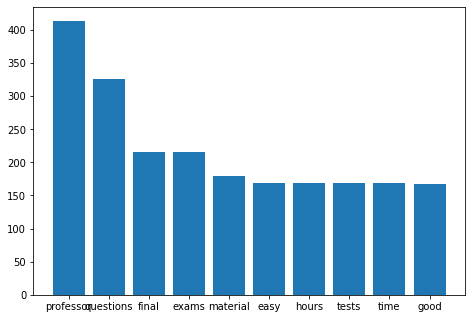

In [16]:
male_reviews = ' '.join([word for review in data_m['Review_Token'] for word in review])
male_review_list = male_reviews.split(' ')
male_freq = defaultdict( int )
for w in male_review_list:
    male_freq[w] += 1
male_freq = {key:val for key,val in male_freq.items() if val > 2}
male_freq_df = pd.DataFrame.from_dict(male_freq,orient='index')
male_freq_df = male_freq_df.reset_index().rename(columns={"index": "word", 0: "frequency"}).sort_values(by=['frequency'],ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(male_freq_df['word'][:10],male_freq_df['frequency'][:10])
plt.show()

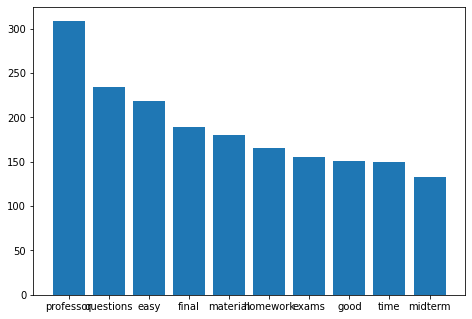

In [17]:
female_reviews = ' '.join([word for review in data_f['Review_Token'] for word in review])
female_review_list = female_reviews.split(' ')
female_review_list
female_freq = defaultdict( int )
for w in female_review_list:
    female_freq[w] += 1
female_freq = {key:val for key,val in female_freq.items() if val > 2}
female_freq_df = pd.DataFrame.from_dict(female_freq,orient='index')
female_freq_df = female_freq_df.reset_index().rename(columns={"index": "word", 0: "frequency"}).sort_values(by=['frequency'],ascending=False)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(female_freq_df['word'][:10],female_freq_df['frequency'][:10])
plt.show()

to do:
- look for ways to filter for sentiment words
- sentiment analysis
- add correlation with grade (once scraped)
- get total number of words in all reviews for F/M to calculate percentages to normalize
-remove names other proper nouns

In [7]:
female_freq_df = pd.read_csv('static/data/female_prof_word_freqs.csv')
male_freq_df = pd.read_csv('static/data/male_prof_word_freqs.csv')
female_freq_df = female_freq_df.sort_values(by='0',ascending=False)
male_freq_df = male_freq_df.sort_values(by='0',ascending=False)
male_freq_df.head()

,Unnamed: 0,0
43,professor,25323
33,final,19485
34,midterm,13751
39,questions,13482
44,easy,12911


In [13]:
new_cols = {'Unnamed: 0':'word','0':'frequency'}
female_freq_df = female_freq_df.rename(columns = new_cols)
male_freq_df = male_freq_df.rename(columns = new_cols)

In [15]:
# Combine female and male freqs
result = pd.merge(female_freq_df, male_freq_df, how="outer", on=["word"])
result.fillna(0, inplace=True)
result = result.rename(columns={"frequency_x": "female", "frequency_y": "male"})
result = result.astype({'female': 'int32','male':'int32'})
result.to_csv('static/data/prof_word_counts.csv',index=False)

In [16]:
result['female'] = result['female']/result['female'].sum() * 100
result['male'] = result['male']/result['male'].sum() * 100
result['difference'] = result['male'] - result['female']
result['difference_abs'] = result['difference'].abs()
result.sort_values(by=['difference_abs'],inplace=True,ascending=False)
result.to_csv('static/data/prof_word_freqs.csv',index=False)

In [23]:
# NOT USING THIS ONE
result2 = pd.melt(result,id_vars=['word'],var_name='gender', value_name='percent')
result2.sort_values(by=['percent'],inplace=True,ascending=False)
# result2['percent'] = result2['percent'] * 100
# result2
result2.to_csv('static/data/prof_word_freqs_tidy.csv',index=False)

In [17]:
result.head()

,word,female,male,difference,difference_abs
1579,guy,0.008490,0.201521,0.193032,0.193032
29,homework,0.323466,0.508800,0.185335,0.185335
94,problems,0.176313,0.351184,0.174871,0.174871
21,readings,0.363453,0.248827,-0.114626,0.114626
369,physics,0.054629,0.145895,0.091266,0.091266


In [18]:
senticnet = pd.read_csv('static/data/senticnet.csv')
senticnet.head()

,CONCEPT,POLARITY VALUE,POLARITY INTENSITY
0,abandon,negative,-0.391
1,abandon_theater,negative,-0.823
2,abandoned,negative,-0.458
3,abandoned_airstrip,negative,-0.771
4,abandoned_farmland,negative,-0.201


In [34]:
list(result.columns) + ['hi','bye']

['word', 'female', 'male', 'difference', 'difference_abs', 'hi', 'bye']

In [19]:
result_sent = result.merge(senticnet, how='inner',left_on='word', right_on='CONCEPT').drop(['CONCEPT'],axis=1)
result_sent.head()

,word,female,male,difference,difference_abs,POLARITY VALUE,POLARITY INTENSITY
0,homework,0.323466,0.508800,0.185335,0.185335,negative,-0.401
1,problems,0.176313,0.351184,0.174871,0.174871,negative,-0.487
2,readings,0.363453,0.248827,-0.114626,0.114626,positive,0.819
3,physics,0.054629,0.145895,0.091266,0.091266,positive,0.812
4,group,0.178281,0.092623,-0.085658,0.085658,positive,0.831


In [20]:
test_text = ['an','apple','is','sometimes','red']
posTagged = pos_tag(test_text)
simplifiedTags = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in posTagged]
print(simplifiedTags)

[('an', 'DET'), ('apple', 'NOUN'), ('is', 'VERB'), ('sometimes', 'ADV'), ('red', 'ADJ')]


In [56]:
posTagged = pos_tag(result_sent.word)
result_sent['POS'] = [map_tag('en-ptb', 'universal', tag) for word, tag in posTagged]
result_sent.head()
result_sent.to_csv('static/data/prof_word_freqs_POS.csv',index=False)

In [3]:
big_data = pd.read_csv('prof_sentiment.csv')
big_data.head()

,overall_rating,easiness_rating,workload_rating,clarity_rating,helpfulness_rating,quarter_taken,year_taken,grade_received,course_slug,prof_slug,...,date,pre_covid,bigrams,gender_guess,sentiment,pos_score,neg_score,review_is_positive,upper_div,review_filt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chem-153c,carla-m-koehler,...,03/24/2002,True,"[(""let's"", 'face'), ('face', 'it.'), ('it.', '...",Female,"{'neg': 0.086, 'neu': 0.822, 'pos': 0.093, 'co...",0.093,0.086,True,True,let face brings powerpoint slides good nice pe...
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,anthro-1,robert-boyd,...,03/21/2005,True,"[('the', 'book'), ('book', 'for'), ('for', 'th...",Male,"{'neg': 0.07, 'neu': 0.838, 'pos': 0.092, 'com...",0.092,0.070,True,False,book course main points chapter consequently r...
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chem-20l,robert-w-kojima,...,05/31/2011,True,"[('definitely', 'avoid'), ('avoid', 'vigano,')...",Male,"{'neg': 0.177, 'neu': 0.696, 'pos': 0.127, 'co...",0.127,0.177,False,False,definitely avoid vigano e ta super nitpicky ta...
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hist-111c,james-l-gelvin,...,03/30/2012,True,"[('i', 'took'), ('took', 'his'), ('his', 'clas...",Male,"{'neg': 0.046, 'neu': 0.783, 'pos': 0.171, 'co...",0.171,0.046,True,True,arab uprisings great exceptionally well-organi...
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,anthro-4,alessandro-duranti,...,03/23/2004,True,"[('the', 'one'), ('one', 'and'), ('and', 'only...",Male,"{'neg': 0.237, 'neu': 0.724, 'pos': 0.039, 'co...",0.039,0.237,False,False,anthro ucla bunch books boring fell asleep oft...


In [4]:
print(big_data['gender_guess'].value_counts())
big_data['gender_guess'].value_counts()/len(big_data.index)

Male      32523
Female    13427
Unsure      364
Name: gender_guess, dtype: int64


Male      0.702228
Female    0.289912
Unsure    0.007859
Name: gender_guess, dtype: float64

In [5]:
big_data.columns

Index(['overall_rating', 'easiness_rating', 'workload_rating',
       'clarity_rating', 'helpfulness_rating', 'quarter_taken', 'year_taken',
       'grade_received', 'course_slug', 'prof_slug', 'review', 'date',
       'pre_covid', 'bigrams', 'gender_guess', 'sentiment', 'pos_score',
       'neg_score', 'review_is_positive', 'upper_div', 'review_filt'],
      dtype='object')

In [11]:
class_cts = big_data['course_slug'].value_counts()
class_pcts = big_data['course_slug'].value_counts()/len(big_data.index)
# class_cts.index
class_df = pd.DataFrame(list(zip(class_cts,class_pcts)),columns=['Counts','Percents'],index=class_cts.index)
class_df.to_csv('class_counts.csv')

In [21]:
dept = ['-'.join(slug.split('-')[:-1]) for slug in class_cts.index]
class_df['dept'] = dept
dept_df = class_df.groupby(['dept']).sum().sort_values('Counts',ascending=False)

In [ ]:
dept_df.to_csv('dept_counts.csv')

Percent diff -> Percent change

In [2]:
freq_data = pd.read_csv('static/data/prof_word_freqs_POS.csv')
freq_data.head()

,word,female,male,difference,difference_abs,POLARITY VALUE,POLARITY INTENSITY,POS
0,homework,0.323466,0.508800,0.185335,0.185335,negative,-0.401,NOUN
1,problems,0.176313,0.351184,0.174871,0.174871,negative,-0.487,NOUN
2,readings,0.363453,0.248827,-0.114626,0.114626,positive,0.819,VERB
3,physics,0.054629,0.145895,0.091266,0.091266,positive,0.812,NOUN
4,group,0.178281,0.092623,-0.085658,0.085658,positive,0.831,NOUN


In [18]:
print(len(freq_data.index))
freq_data2 = freq_data.loc[(freq_data.female != 0) & (freq_data.male != 0),]
len(freq_data2.index)

11564


6743

In [19]:
def get_pct_change(row):
    larger = max(row.female,row.male)
    smaller = min(row.female,row.male)
    row['pct_change'] = larger/smaller
    return row

In [21]:
freq_data2= freq_data2.apply(lambda row: get_pct_change(row),axis=1)
freq_data2.sort_values('pct_change')
# freq_data.to_csv('static/data/prof_word_freqs_POS.csv',index=False)

,word,female,male,difference,difference_abs,POLARITY VALUE,POLARITY INTENSITY,POS,pct_change
11563,flat,0.002461,0.002459,-0.000001,0.000001,negative,-0.862,ADJ,1.000513
11561,afford,0.002092,0.002093,0.000002,0.000002,positive,0.186,NOUN,1.000738
11562,similarly,0.002092,0.002093,0.000002,0.000002,positive,0.855,ADV,1.000738
11512,impression,0.006275,0.006280,0.000005,0.000005,positive,0.800,NOUN,1.000738
11515,connected,0.004183,0.004186,0.000003,0.000003,negative,-0.750,ADJ,1.000738
...,...,...,...,...,...,...,...,...,...
692,parkinson,0.001969,0.000052,-0.001916,0.001916,negative,-0.892,NOUN,37.619292
97,beatles,0.011073,0.000209,-0.010864,0.010864,positive,0.833,VERB,52.902130
87,reilly,0.011689,0.000209,-0.011479,0.011479,negative,-0.866,NOUN,55.841137
149,gillespie,0.000123,0.008006,0.007883,0.007883,positive,0.596,NOUN,65.072994
